
# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur adjoint au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>

Le projet a été développé à l'aide de Alice Breton, étudiante à la maîtrise en génie informatique. Elle a suivi le cours lors de la session Hiver 2019.



# Projet : Débordement d'égouts

La description du projet est disponible à l'adresse suivante :
https://www.kaggle.com/t/a238b752c33a41d9803c2cdde6bfc929

Ce calepin Jupyter de base permet de charger et de nettoyer les données fournies. La dernière section détaille la génération du fichier des prédictions afin de le soumettre sur Kaggle dans le bon format.

Dans un premier temps, vous devrez récupérer l'archive *data.zip* sur Moodle. Ce dossier contient les fichiers suivants :
- surverses.csv
- precipitation.csv
- ouvrages-surverses.csv
- test.csv

Veuillez le décompresser dans le répertoire de ce calepin.

Le fichier *surverse.csv* répertorie s'il y a surverse (1) ou non (0) au cours de la journée pour les 170 ouvrages de débordement de 2013 à 2018 pour les mois de mai à octobre (inclusivement). Des renseignements additionnels sur les données sont disponibles à l'adresse suivante :

http://donnees.ville.montreal.qc.ca/dataset/debordement


Le fichier *precipitation.csv* contient les précipitations horaires en dixième de *mm* enregistrées à 5 stations pluviométriques de 2013 à 2019 :
- McTavish (7024745)
- Ste-Anne-de-Bellevue (702FHL8)
- Montreal/Pierre Elliott Trudeau Intl (702S006)
- Montreal/St-Hubert (7027329)
- L’Assomption (7014160)

Plus d'informations sur les précipitations sont disponibles à l'adresse suivante :

https://climat.meteo.gc.ca/climate_data/hourly_data_f.html?hlyRange=2008-01-08%7C2019-11-12&dlyRange=2002-12-23%7C2019-11-12&mlyRange=%7C&StationID=30165&Prov=QC&urlExtension=_f.html&searchType=stnName&optLimit=yearRange&StartYear=1840&EndYear=2019&selRowPerPage=25&Line=17&searchMethod=contains&Month=11&Day=12&txtStationName=montreal&timeframe=1&Year=2019

Le fichier *ouvrages-surverses.csv* contient différentes caractéristiques des ouvrages de débordement. 

http://donnees.ville.montreal.qc.ca/dataset/ouvrage-surverse

Le fichier *test.csv* contient les ouvrages et les jours pour lesquels vous devez prédire s'il y a eu surverse (true) ou non (false). Notez que l'on s'intéresse ici à 5 ouvrages de débordement localisés tout autour de l'Ile de Montréal :
- 3260-01D dans Rivière-des-Prairies 
- 3350-07D dans Ahunstic 
- 4240-01D dans Pointe-aux-Trembles 
- 4350-01D dans le Vieux-Montréal 
- 4380-01D dans Verdun

#### Remarque

Dans le projet, on ne s'intéresse qu'aux surverses occasionnées par les précipitations. On ignore les surverses occasionnées par 
- fonte de neige (F)
- travaux planifiés et entretien (TPL)
- urgence (U)
- autre (AUT)

On suppose que lorsqu'il n'y a pas de raison pour la surverse, il s'agit d'une surverse causée par les précipitations. Puisque Nous nous intéresserons uniquement aux surverses occasionnées par les précipitations liquides, nous ne considérons que les mois de mai à octobre inclusivement.

In [1]:
using CSV, DataFrames, Statistics, Dates, Gadfly, Random, LinearAlgebra, GLM, Distributions, Combinatorics, StatsBase, DecisionTree
include("functions.jl");

┌ Info: Recompiling stale cache file C:\Users\gaspa\.julia\compiled\v1.2\CSV\HHBkp.ji for CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file C:\Users\gaspa\.julia\compiled\v1.2\Gadfly\DvECm.ji for Gadfly [c91e804a-d5a3-530f-b6f0-dfbca275c004]
└ @ Base loading.jl:1240
┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly C:\Users\gaspa\.julia\packages\Gadfly\09PWZ\src\mapping.jl:228
┌ Info: Recompiling stale cache file C:\Users\gaspa\.julia\compiled\v1.2\GLM\6OREG.ji for GLM [38e38edf-8417-5370-95a0-9cbb8c7f171a]
└ @ Base loading.jl:1240


# Chargement des données et nettoyage préliminaire

## Chargement et nettoyage des surverses et précipitations

In [46]:
data = CSV.read("data/surverses.csv",missingstring="-99999")
first(data,5)

# Extraction des surverses pour les mois de mai à octobre inclusivement
data = filter(row -> month(row.DATE) > 4, data) 
data = filter(row -> month(row.DATE) < 11, data) 

# Remplacement des valeurs *missing* dans la colonne :RAISON par "Inconnue"
raison = coalesce.(data[:,:RAISON],"Inconnue")
data[!,:RAISON] = raison

# Exlusion des surverses coccasionnées par d'autres facteurs que les précipitations liquides
data = filter(row -> row.RAISON ∈ ["P","Inconnue","TS"], data) 
select!(data, [:NO_OUVRAGE, :DATE, :SURVERSE])

surverse_df = dropmissing(data, disallowmissing=true)

### CHARGEMENT DES PRÉCIPITATIONS
data = CSV.read("data/precipitations.csv",missingstring="-99999")
rename!(data, Symbol("St-Hubert")=>:StHubert)

# Nettoyage des données sur les précipitations
data = filter(row -> month(row.date) > 4, data) 
data = filter(row -> month(row.date) < 11, data);


In [47]:
# REMPLACER LES VALEURS MANQUANTES DANS LE DATAFRAME DE PRÉCIPITATIONS
# On veut remplacer les données manquante grâce à une simple régression linéaire (Ridge).
# Pour ce faire, chaque station météo agira comme variable explicative pour les 4 autres
# On drop les rangées dont les 5valeurs sont missing

data_full = deepcopy(data)
dropmissing!(data, disallowmissing=true)

models = Dict()

for i = 1:length(data_full[:, 1])
    if any(ismissing, data_full[i, 3:7]) #ismissing c est pas une variable mais une méthode de Julia, 3:7 pour les 5 stations
        missing = []
        notmissing = []
        for j=3:7 #on passe à travers les 5 colonnes pour regarder celles qui sont missing ou non
            if ismissing(data_full[i, j])
                push!(missing, names(data_full)[j]) #push généralisé à tous les conteneurs
                #Le point d exclamation pour dire à la fonction de modifier le conteneur qu on lui passe
            else
                push!(notmissing, names(data_full)[j])
            end
        end
        
        if length(notmissing) > 0 #si on a 5 missing sur la ligne on peut juste rien prédire donc on skip ça
            for m in missing #m c est la station à prédire
                if !haskey(models, (m, notmissing)) #ça véfirie si dans le dictionnaire models il y a la key (m, notmissing)
                    models[(m, notmissing)] = CoeffRidge(data, m, notmissing) #on change la case dans le dico palr le coef que la fonction nous retourne
                end
                data_full[i, m] = round(convert(Vector{Float64}, data_full[i, notmissing])' * models[(m, notmissing)]) # on ajoute à la case manque la nouvelle valeur = x*Beta
            end
        end
    end
end

dropmissing!(data_full);



## Enlever les données aberrantes somehow

In [48]:
data_full[3902, 3] = 0
data_full[3902, 7] = 0

0

## Extraction variables explicatives (Maude L.)

In [49]:
# Maximum de précipitations en 1 heure dans une journée.
X_pcp_max = by(data_full, :date,  MAXMcTavish = :McTavish=>maximum, MAXBellevue = :Bellevue=>maximum, 
   MAXAssomption = :Assomption=>maximum, MAXTrudeau = :Trudeau=>maximum, MAXStHubert = :StHubert=>maximum)

# Somme des précipitations dans une journée
X_pcp_sum = by(data_full, :date,  SUMMcTavish = :McTavish=>sum, SUMBellevue = :Bellevue=>sum, 
   SUMAssomption = :Assomption=>sum, SUMTrudeau = :Trudeau=>sum, SUMStHubert = :StHubert=>sum)

# Précipitation à chaque heure pour chaque journée
X_pcp_hour = data_full

# Somme des précipitations des 2 heures précédentes

X_pcp_three_hours = copy(data_full)
buffer = copy(data_full)
for i=3:7
    for j=1:length(data_full[:,2])
        if (j > 2)
            X_pcp_three_hours[j, i] = (buffer[(j-2), i] + buffer[(j-1), i] + buffer[j,i])
        else
            X_pcp_three_hours[j, i] = buffer[j, i]
        end
    end
end

# Somme des précipitations des 2 jours précédents

X_pcp_two_days = DataFrame(date= X_pcp_sum[:,:date], SUM2DaysMcTavish=zeros(Int64, length(X_pcp_sum[:,1])), SUM2DaysBellevue=zeros(Int64, length(X_pcp_sum[:,1])), SUM2DaysAssomption=zeros(Int64, length(X_pcp_sum[:,1])), SUM2DaysTrudeau=zeros(Int64, length(X_pcp_sum[:,1])), SUM2DaysStHubert=zeros(Int64, length(X_pcp_sum[:,1])))
#buffer = copy(X_pcp_sum)
for i=2:6
    for j=1:length(X_pcp_two_days[:,1])
        if (j > 1)
            X_pcp_two_days[j, i] = X_pcp_sum[(j-1), i] + X_pcp_sum[j,i]
        else
            X_pcp_two_days[j, i] = X_pcp_sum[j, i]
        end
    end
end


# Mois de la prédiction pour chaque ouvrage
X_date = DataFrame(NO_OUVRAGE=surverse_df[:,:NO_OUVRAGE], MOIS=zeros(Int64,length(surverse_df[:,1])), SURVERSE=surverse_df[:,:SURVERSE])
for i=1:length(surverse_df[:,1])
    X_date[i,:MOIS] = month(surverse_df[i,:DATE])
end

X_mois = DataFrame(MOIS=["Mai", "Juin", "Juillet", "Août", "Septembre", "Octobre"], RivierePrairie=zeros(Int64,6), Ahuntsic=zeros(Int64,6), PointeAuxTrembles=zeros(Int64,6), VieuxMontreal=zeros(Int64,6), Verdun=zeros(Int64,6))
for j=1:length(X_date[:,1])
    if(X_date[j,1] == "3260-01D")
        X_mois[(X_date[j,2]-4),:RivierePrairie] += (X_date[j,3])
    elseif (X_date[j,1] == "3350-07D")
        X_mois[(X_date[j,2]-4),:Ahuntsic] += (X_date[j,3])
    elseif (X_date[j,1] == "4240-01D")
        X_mois[(X_date[j,2]-4),:PointeAuxTrembles] += (X_date[j,3])
    elseif (X_date[j,1] == "4350-01D")
        X_mois[(X_date[j,2]-4),:VieuxMontreal] += (X_date[j,3])
    elseif (X_date[j,1] == "4380-01D")
        X_mois[(X_date[j,2]-4),:Verdun] += (X_date[j,3])
    end
end


In [50]:
# Création de 5 dataframes séparés pour les données de surverses des 5 ouvrages d'intérêt
ouvrage = ["3260-01D", "3350-07D", "4240-01D", "4350-01D", "4380-01D"]

filtered_surverse = filter(row -> row.NO_OUVRAGE == ouvrage[1], surverse_df)
surverse_rivierePrairie = DataFrame(DATE=filtered_surverse[:, 2], SURVERSE=filtered_surverse[:, 3])

filtered_surverse = filter(row -> row.NO_OUVRAGE == ouvrage[2], surverse_df)
surverse_ahuntsic = DataFrame(DATE=filtered_surverse[:, 2], SURVERSE=filtered_surverse[:, 3])

filtered_surverse = filter(row -> row.NO_OUVRAGE == ouvrage[3], surverse_df)
surverse_pointeAuxTrembles = DataFrame(DATE=filtered_surverse[:, 2], SURVERSE=filtered_surverse[:, 3])

filtered_surverse = filter(row -> row.NO_OUVRAGE == ouvrage[4], surverse_df)
surverse_vieuxMontreal = DataFrame(DATE=filtered_surverse[:, 2], SURVERSE=filtered_surverse[:, 3])

filtered_surverse = filter(row -> row.NO_OUVRAGE == ouvrage[5], surverse_df)
surverse_verdun = DataFrame(DATE=filtered_surverse[:, 2], SURVERSE=filtered_surverse[:, 3]);


## Création de variables explicatives représentant la densité de pluie tombée selon les heures
Afin de prendre en considération une quantité de précipitations importantes tombées en une courte période de temps, nous avons calculé pour chaque heure de la journée, la somme des précipitations des deux heures précédentes avec les précipitations de l'heure courante. À partir de cela, nous avons créé la variable MAXPCP3HOURS qui présente la quantité maximale de pluie par bloc de 3 heures dans une journée, et la variable NUMBLOCK qui représente le nombre de bloc de 3 heures ayant une somme de précipitations plus élevé qu'un seuil déterminé en essayant différents seuil et en représentant graphiquement la discrimination entre les journées avec surverse et sans surverse, selon le seuil choisi.

In [51]:
function aboveThreshold(x::Array{Int64,1}, threshold::Int64)
    num = 0
    for j=1:length(x)
        if x[j] > threshold
            num += 1
        end
    end
    return num
end

aboveThreshold (generic function with 1 method)

In [52]:
## Dataframe avec le maximum de précipitations dans chaque bloc de 3 heures, et le nombre de bloc de 3 heures
## ayant eu plus que 75 mm de précipitations.
df_3h = DataFrame(date=X_pcp_sum[:, :date], MAXBLOCMcTavish=zeros(Int64, length(X_pcp_sum[:,1])), MAXBLOCBellevue=zeros(Int64, length(X_pcp_sum[:,1])), MAXBLOCAssomption=zeros(Int64, length(X_pcp_sum[:,1])), MAXBLOCTrudeau=zeros(Int64, length(X_pcp_sum[:,1])), MAXBLOCStHubert=zeros(Int64, length(X_pcp_sum[:,1])), BLOCMcTavish=zeros(Int64, length(X_pcp_sum[:,1])), BLOCBellevue=zeros(Int64, length(X_pcp_sum[:,1])), BLOCAssomption=zeros(Int64, length(X_pcp_sum[:,1])), BLOCTrudeau=zeros(Int64, length(X_pcp_sum[:,1])), BLOCStHubert=zeros(Int64, length(X_pcp_sum[:,1])))
for i=1:length(X_pcp_sum[:,1])-1
    for j=2:6
        df_3h[i, j] = findmax(X_pcp_three_hours[((i-1)*24)+1:i*24, j+1])[1]
    end
    for j=7:11
        df_3h[i, j] = aboveThreshold(X_pcp_three_hours[((i-1)*24)+1:i*24, j-4], 75)
    end
end

In [53]:
## X_max_3h est la variable avec le maximum de précipitations par 3 heures
## X_bloc_3h est la variable avec le nombre de blocs ayant eu plus que 75 mm de précipitations
X_max_3h = df_3h[!, 1:6]
X_bloc_3h = df_3h[!, 7:11]
insert!(X_bloc_3h, 1, df_3h[!, 1], :date);

┌ Warning: `insert!(df::DataFrame, col_ind::Int, item, name::Symbol; makeunique::Bool=false)` is deprecated, use `insertcols!(df, col_ind, name => item; makeunique=makeunique)` instead.
│   caller = top-level scope at In[53]:5
└ @ Core In[53]:5


In [54]:
## Dataframe pour le plot d'en dessous
df_3h_3260 = copy(df_3h)
df_3h_3260.SURVERSE = zeros(Int64, length(df_3h[:,1]))
missing = []
for i=1:length(df_3h_3260[:,1])
    surverse = filter(x -> x.DATE == df_3h[i, :date], surverse_vieuxMontreal).SURVERSE
    if length(surverse) != 0
        df_3h_3260[i, :SURVERSE] = surverse[1]
    else
        push!(missing, i)
    end
end
deleterows!(df_3h_3260, missing);

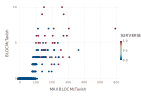

In [55]:
## Plot pour déterminer ish le seuil de précipitations par bloc de 3 heures
plot(df_3h_3260,x="MAXBLOCMcTavish", y="BLOCMcTavish", color=:SURVERSE, Geom.beeswarm)

# Analyse exploratoire

Cette section consitue une analyse exploratoire superficielle permettant de voir s'il existe un lien entre les précipitations et les surverses.

Prenons arbitrairement l'ouvrage de débordement près du Bota-Bota (4350-01D). La station météorologique la plus proche est McTavish. Prenons deux variables explicatives simple :
- la somme journalière des précipitations
- le taux horaire maximum journalier de précipitations

#### Calcul de la quantité journalière de précipitations pour chacune des stations météorologiques

# Modèle #1: Régression logistique 

### Écrire une description 

In [56]:
# Construction d'un dataframe contenant toutes les variables explicatives

function CreateDataframe(ouvrage, surverse_df)
    df_train = filter(row -> row.NO_OUVRAGE == ouvrage, surverse_df)

    x₁ = Array{Int64}(undef, size(df_train,1)) # variable pour la somme journalière McTavish
    x₂ = Array{Int64}(undef, size(df_train,1)) # variable pour la somme journalière Bellevue
    x₃ = Array{Int64}(undef, size(df_train,1)) # variable pour la somme journalière Assomption
    x₄ = Array{Int64}(undef, size(df_train,1)) # variable pour la somme journalière PET
    x₅ = Array{Int64}(undef, size(df_train,1)) # variable pour la somme journalière St-Hubert
    x₆ = Array{Int64}(undef, size(df_train,1)) # variable pour la somme des 2 jours McTavish
    x₇ = Array{Int64}(undef, size(df_train,1)) # variable pour la somme des 2 jours Bellevue
    x₈ = Array{Int64}(undef, size(df_train,1)) # variable pour la somme des 2 jours Assomption
    x₉ = Array{Int64}(undef, size(df_train,1)) # variable pour la somme des 2 jours PET
    x₁₀ = Array{Int64}(undef, size(df_train,1)) # variable pour la somme des 2 jours St-Hubert
    x₁₁ = Array{Int64}(undef, size(df_train,1)) # variable pour le max journalier McTavish
    x₁₂ = Array{Int64}(undef, size(df_train,1)) # variable pour le max journalier Bellevue
    x₁₃ = Array{Int64}(undef, size(df_train,1)) # variable pour le max journalier Assomption
    x₁₄ = Array{Int64}(undef, size(df_train,1)) # variable pour le max journalier PET
    x₁₅ = Array{Int64}(undef, size(df_train,1)) # variable pour le max journalier St-Hubert
    x₁₆ = Array{Int64}(undef, size(df_train,1)) # variable pour le max par bloc de 3h McTavish
    x₁₇ = Array{Int64}(undef, size(df_train,1)) # variable pour le max par bloc de 3h Bellevue
    x₁₈ = Array{Int64}(undef, size(df_train,1)) # variable pour le max par bloc de 3h Assomption
    x₁₉ = Array{Int64}(undef, size(df_train,1)) # variable pour le max par bloc de 3h PET
    x₂₀ = Array{Int64}(undef, size(df_train,1)) # variable pour le max par bloc de 3h St-Hubert
    x₂₁ = Array{Int64}(undef, size(df_train,1)) # variable pour le nombre de blocs de 3h avec plus de 75 mm de pluie McTavish
    x₂₂ = Array{Int64}(undef, size(df_train,1)) # variable pour le nombre de blocs de 3h avec plus de 75 mm de pluie Bellevue
    x₂₃ = Array{Int64}(undef, size(df_train,1)) # variable pour le nombre de blocs de 3h avec plus de 75 mm de pluie Assomption
    x₂₄ = Array{Int64}(undef, size(df_train,1)) # variable pour le nombre de blocs de 3h avec plus de 75 mm de pluie PET
    x₂₅ = Array{Int64}(undef, size(df_train,1)) # variable pour le nombre de blocs de 3h avec plus de 75 mm de pluie St-Hubert



    for i=1:size(df_train,1)

        ind = findfirst(X_pcp_sum[:,:date] .== df_train[i,:DATE])
        
        x₁[i] = X_pcp_sum[ind,:SUMMcTavish]

        x₂[i] = X_pcp_sum[ind,:SUMBellevue]

        x₃[i] = X_pcp_sum[ind,:SUMAssomption]

        x₄[i] = X_pcp_sum[ind,:SUMTrudeau]

        x₅[i] = X_pcp_sum[ind,:SUMStHubert]
        
        ind = findfirst(X_pcp_two_days[:,:date] .== df_train[i,:DATE])

        x₆[i] = X_pcp_two_days[ind, :SUM2DaysMcTavish]

        x₇[i] = X_pcp_two_days[ind, :SUM2DaysBellevue]

        x₈[i] = X_pcp_two_days[ind, :SUM2DaysAssomption]

        x₉[i] = X_pcp_two_days[ind, :SUM2DaysTrudeau]

        x₁₀[i] = X_pcp_two_days[ind, :SUM2DaysStHubert]
        
        ind = findfirst(X_pcp_max[:,:date] .== df_train[i,:DATE])

        x₁₁[i] = X_pcp_max[ind, :MAXMcTavish]

        x₁₂[i] = X_pcp_max[ind, :MAXBellevue]

        x₁₃[i] = X_pcp_max[ind, :MAXAssomption]

        x₁₄[i] = X_pcp_max[ind, :MAXTrudeau]

        x₁₅[i] = X_pcp_max[ind, :MAXStHubert]
        
        ind = findfirst(X_max_3h[:,:date] .== df_train[i,:DATE])
        
        x₁₆[i] = X_max_3h[ind, :MAXBLOCMcTavish]
        
        x₁₇[i] = X_max_3h[ind, :MAXBLOCBellevue]
        
        x₁₈[i] = X_max_3h[ind, :MAXBLOCAssomption]
        
        x₁₉[i] = X_max_3h[ind, :MAXBLOCTrudeau]
        
        x₂₀[i] = X_max_3h[ind, :MAXBLOCStHubert]
        
        ind = findfirst(X_bloc_3h[:,:date] .== df_train[i,:DATE])
        
        x₂₁[i] = X_bloc_3h[ind, :BLOCMcTavish]
        
        x₂₂[i] = X_bloc_3h[ind, :BLOCBellevue]
        
        x₂₃[i] = X_bloc_3h[ind, :BLOCAssomption]
        
        x₂₄[i] = X_bloc_3h[ind, :BLOCTrudeau]
        
        x₂₅[i] = X_bloc_3h[ind, :BLOCStHubert]

    end

    df_train[!,:SUMMcTavish] = x₁
    df_train[!,:SUMBellevue] = x₂
    df_train[!,:SUMAssomption] = x₃
    df_train[!,:SUMStHubert] = x₄
    df_train[!,:SUMPET] = x₅
    df_train[!,:SUM2McTavish] = x₆
    df_train[!,:SUM2Bellevue] = x₇
    df_train[!,:SUM2Assomption] = x₈
    df_train[!,:SUM2StHubert] = x₉
    df_train[!,:SUM2PET] = x₁₀
    df_train[!,:MAXMcTavish] = x₁₁
    df_train[!,:MAXBellevue] = x₁₂
    df_train[!,:MAXAssomption] = x₁₃
    df_train[!,:MAXStHubert] = x₁₄
    df_train[!,:MAXPET] = x₁₅
    df_train[!, :MAXBLOCMcTavish] = x₁₆
    df_train[!, :MAXBLOCBellevue] = x₁₇
    df_train[!, :MAXBLOCAssomption] = x₁₈
    df_train[!, :MAXBLOCTrudeau] = x₁₉
    df_train[!, :MAXBLOCStHubert] = x₂₀
    df_train[!, :BLOCMcTavish] = x₂₁
    df_train[!, :BLOCBellevue] = x₂₂
    df_train[!, :BLOCAssomption] = x₂₃
    df_train[!, :BLOCTrudeau] = x₂₄
    df_train[!, :BLOCStHubert] = x₂₅
    
    return df_train

end


CreateDataframe (generic function with 1 method)

In [81]:
function getForest(num_ouvrage)
    train = CreateDataframe(num_ouvrage, surverse_df)
    y = train[:SURVERSE]
    X = convert(Matrix{Float64}, train[:, 4:28])
        
    #5 features as √p = 5, p = 25 features, 100 trees, 10 folds of cross-validation
    subfeatures = 5
    n_trees = 50
    partial_sampling = 0.8
    max_depth = 5
    min_samples_leaf = 5
    min_samples_split = 2
    min_purity_increase=0.0
    
    n_folds = 2
    
    return build_forest(y, X,
                        subfeatures,
                        n_trees,
                        partial_sampling,
                        max_depth,
                        min_samples_leaf,
                        min_samples_split,
                        min_purity_increase)

    #, nfoldCV_forest(y, X, n_folds, subfeatures)
end

getForest (generic function with 1 method)

In [82]:
ouvrage = ["3260-01D", "3350-07D", "4240-01D", "4350-01D", "4380-01D"]
best_models = Dict()

for i=1:length(ouvrage)
    best_models[ouvrage[i]] = getForest(ouvrage[1])
    println(ouvrage[i], " done")
end

print_tree(best_models[ouvrage[1]].trees[1])

3260-01D done


┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = getForest(::String) at In[81]:3
└ @ Main .\In[81]:3


3350-07D done
4240-01D done
4350-01D done
4380-01D done
Feature 20, Threshold 35.5
L-> Feature 6, Threshold 67.0
    L-> 0 : 610/610
    R-> Feature 5, Threshold 24.5
        L-> Feature 6, Threshold 103.0
            L-> 0 : 35/35
            R-> Feature 9, Threshold 105.0
                L-> 0 : 24/24
                R-> 0 : 31/34
        R-> Feature 14, Threshold 9.5
            L-> 1 : 5/5
            R-> Feature 12, Threshold 20.5
                L-> 0 : 4/5
                R-> 0 : 11/11
R-> Feature 5, Threshold 165.0
    L-> Feature 7, Threshold 262.0
        L-> Feature 3, Threshold 79.0
            L-> Feature 14, Threshold 19.5
                L-> 0 : 19/19
                R-> 0 : 31/36
            R-> Feature 19, Threshold 106.5
                L-> 0 : 24/30
                R-> 1 : 7/7
        R-> Feature 9, Threshold 353.0
            L-> 1 : 4/6
            R-> 1 : 6/6
    R-> Feature 22, Threshold 0.5
        L-> Feature 8, Threshold 250.0
            L-> 0 : 6/7
         

# Création du fichier de prédictions pour soumettre sur Kaggle

Dans ce cas-ci, nous prédirons une surverse avec une probabilité de 1/2 sans considérer aucune variable explicative.

In [33]:
function getVarEx(date::Date)
    row_sum = filter(row-> row.date== date, X_pcp_sum)
    row_sum_2_days = filter(row-> row.date== date, X_pcp_two_days)
    row_max = filter(row-> row.date== date, X_pcp_max)
    row_max_3h = filter(row->row.date== date, X_max_3h)
    row_bloc_3h = filter(row->row.date==date, X_bloc_3h)
    total_row = join(row_sum, row_sum_2_days, on = :date)
    total_row = join(total_row, row_max, on = :date)
    total_row = join(total_row, row_max_3h, on = :date)
    total_row = join(total_row, row_bloc_3h, on = :date)
    
    return total_row
end

getVarEx (generic function with 1 method)

In [35]:
## Pas classe, je sais
function dfRowTo2D(row::DataFrameRow)
    X = Array{Float64, 2}(undef, 1, length(row))
    for i=1:length(row)
        X[1, i] = row[i]
    end
    return X
end

dfRowTo2D (generic function with 1 method)

In [45]:
## Chargement du fichier de test
test = CSV.read("data/test.csv")
hcat(test, DataFrame(SURVERSE=zeros(Int64, length(test[:,1]))))
rename!(test, :DATE => :date)

## Dataframe des dates et ouvrages à prédire avec toutes les variables explicatives
df_test = getVarEx(test[1, :date])
for i=2:length(test[:,1])
    push!(df_test, convert(Array, getVarEx(test[i, :date])))
end
insert!(df_test, 1, test[:, :NO_OUVRAGE], :NO_OUVRAGE)
insert!(df_test, 3, zeros(Int64, length(df_test[:,1])), :surverse)
#insert!(df_test, 4, ones(Float64, length(df_test[:,1])), :x1)

## Calcul de la probabilité de surverse
for i=1:length(df_test[:,1])
    M = best_models[df_test[i, :NO_OUVRAGE]]
    Exp = dfRowTo2D(df_test[i,4:28])
    df_test[i, :surverse] = apply_forest(M, Exp)[1]
end

# Création du fichier sampleSubmission.csv pour soumettre sur Kaggle
ID = test[:,:NO_OUVRAGE].*"_".*string.(test[:,:date])
sampleSubmission = DataFrame(ID = ID, Surverse=df_test[:,:surverse])
CSV.write("sampleSubmission_with_5_variables_random_forest.csv",sampleSubmission)

# Vous pouvez par la suite déposer le fichier sampleSubmission.csv sur Kaggle.

┌ Warning: `insert!(df::DataFrame, col_ind::Int, item, name::Symbol; makeunique::Bool=false)` is deprecated, use `insertcols!(df, col_ind, name => item; makeunique=makeunique)` instead.
│   caller = top-level scope at In[45]:11
└ @ Core In[45]:11
┌ Warning: `insert!(df::DataFrame, col_ind::Int, item, name::Symbol; makeunique::Bool=false)` is deprecated, use `insertcols!(df, col_ind, name => item; makeunique=makeunique)` instead.
│   caller = top-level scope at In[45]:12
└ @ Core In[45]:12


"sampleSubmission_with_5_variables_random_forest.csv"